Attempting to see if we can use ingredients and keywords to predict a rating.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

Over 20,000 recipes with an average rating of 3.71. The 25th percentile is above the mean, so there is most likely an outlier population. (A lot times this happens with reviews, some bad recipes may have very few very low reviews).

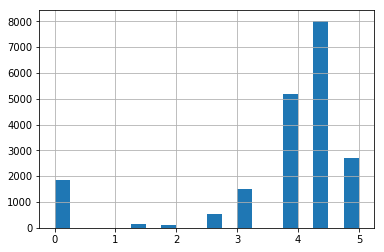

In [5]:
raw_data.rating.hist(bins=20)

Sharp discontinutities, no continuous data, large anticipated increase at 0.

In [6]:
# begin cleaning data by checking for nulls
null_count = raw_data.isnull().sum()

# excludes those with null 0
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

This time we'll try and drop the nulls and see what happens.

In [7]:
# drop nulls
raw_data = raw_data.dropna()

In [8]:
# turn ratings into a classifier
# in this case we're splitting right down the mean
raw_data['rating'] = np.where(raw_data['rating']>3.71, 1, 0)

In [9]:
# use rfc to determine which features are most improtant

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = raw_data.drop(['rating', 'title'], 1)
Y = raw_data.rating

cross_val_score(rfc, X, Y, cv=10)

array([0.84120983, 0.84310019, 0.83805923, 0.81852552, 0.83984868,
       0.82534678, 0.84993695, 0.8259773 , 0.83606557, 0.8259773 ])

In [10]:
# create dataframe showing important of each columns
df = pd.DataFrame()
df['importance'] = rfc.fit(X, Y).feature_importances_

In [11]:
# sort by importance and excluding all but 30 features
df = df.sort_values(by='importance', ascending = False)
df = df[:30]
df.head()

,importance
0,0.060408
3,0.055784
2,0.051799
1,0.045186
244,0.012667


In [12]:
# turn index into a list and select the 30 most important columns/features
df_list = df.index.T.tolist()
top_30_features = pd.DataFrame()
top_30_features = raw_data.iloc[:, df_list]

In [13]:
# for the sake of time, take a  sample of 1,000 (instead of 20,000)
top_30_features_sample = top_30_features.sample(n=1000)

In [14]:
from sklearn.svm import SVC

# instantiate model and fit the data.
X = top_30_features_sample.drop(['title', 'rating'], 1)
Y = top_30_features_sample.rating
svm = SVC()
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
#perform cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(svm, X, Y, cv=5)

array([0.765, 0.785, 0.77 , 0.785, 0.785])

In [16]:
#find svm score
svm.score(X, Y)

0.846